In [85]:
import csv
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import os
import random

from collections import defaultdict
from surprise import BaselineOnly, Dataset, Reader, accuracy, SVD, SVDpp, NormalPredictor, NMF, SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline
from surprise.model_selection import cross_validate, train_test_split 

In [11]:
all_champs = os.path.expanduser('../data/surprise_data_full.csv')
users_750 = os.path.expanduser('../data/surprise_data_750.csv')

file_path = users_750
reader = Reader(sep=",", rating_scale=(0,1))
data = Dataset.load_from_file(file_path, reader)

# Test various models for our recommendation system

## Test on sample data

Make sure surprise is working

In [2]:
data = Dataset.load_builtin('ml-100k')
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9322  0.9296  0.9384  0.9370  0.9388  0.9352  0.0036  
MAE (testset)     0.7338  0.7308  0.7396  0.7392  0.7414  0.7370  0.0040  
Fit time          0.66    0.68    0.66    0.68    0.67    0.67    0.01    
Test time         0.13    0.17    0.13    0.16    0.17    0.15    0.02    


{'test_rmse': array([0.93215313, 0.92963265, 0.93835287, 0.93702046, 0.93877779]),
 'test_mae': array([0.73384986, 0.73075382, 0.73959879, 0.73924839, 0.74143973]),
 'fit_time': (0.6649699211120605,
  0.6803891658782959,
  0.660426139831543,
  0.6754879951477051,
  0.6742196083068848),
 'test_time': (0.12561893463134766,
  0.1682279109954834,
  0.12775516510009766,
  0.16091489791870117,
  0.16535019874572754)}

## Test KNNWithMeans settings

Test RMSE and MAE values against similarity metrics and against user-user vs. item-item comparisions. Cosine was not tested since it faced issues with the 0 values in the dataset.

In [31]:
options = ['pearson_baseline', 'MSD', 'pearson']
value = [True, False]

results = {}
for opt in options:
    for val in value:            
        sim_options = {
            "name": opt,
            "user_based": val
        }

        algo = KNNWithMeans(sim_options=sim_options)
        res = cross_validate(algo, data, measures=['RMSE', 'MAE', 'FCP'], cv=3, verbose=False)

        if val:
            entry = opt + " (T)"
        else:
            entry = opt + " (F)"

        results[entry] = {"RMSE": res['test_rmse'].mean(), "MAE": res['test_mae'].mean(), 'FCP': res['test_fcp'].mean(), 'Test Time': res['test_time'][-1]}

pearson_baseline True
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE, FCP of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.1215  0.1200  0.1238  0.1218  0.0016  
MAE (testset)     0.0566  0.0562  0.0566  0.0565  0.0002  
FCP (testset)     0.7158  0.7168  0.7201  0.7176  0.0018  
Fit time          1.15    1.14    1.13    1.14    0.01    
Test time         15.76   15.64   15.48   15.63   0.12    
pearson_baseline False
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline sim

User Based comparision took a lot longer than Item based similarity comparision. FCP seems to be maximized and RMSE seems to be minimized when using pearson_baseline.

In [32]:
pprint.pprint(results)

{'MSD (F)': {'FCP': 0.6994992679835622,
             'MAE': 0.05945308723020134,
             'RMSE': 0.12558902909698108,
             'Test Time': 5.722884178161621},
 'MSD (T)': {'FCP': 0.6771551403028048,
             'MAE': 0.06474007153364973,
             'RMSE': 0.1256515549477372,
             'Test Time': 15.47614598274231},
 'pearson (F)': {'FCP': 0.7222791566010586,
                 'MAE': 0.056124864127103324,
                 'RMSE': 0.12188185337670543,
                 'Test Time': 5.622877836227417},
 'pearson (T)': {'FCP': 0.7111174333449434,
                 'MAE': 0.055987777638981044,
                 'RMSE': 0.12175384168754415,
                 'Test Time': 15.393117904663086},
 'pearson_baseline (F)': {'FCP': 0.7310902060512553,
                          'MAE': 0.054675774690060845,
                          'RMSE': 0.12109839726403208,
                          'Test Time': 5.651664972305298},
 'pearson_baseline (T)': {'FCP': 0.7175704680144955,
               

In [33]:
x = np.arange(5, 60, 5)
y = np.zeros_like(x, dtype=float)

sim_options = {
    "name": "pearson_baseline",
    "user_based": False
}

for i, n in enumerate(x):
    algo = KNNWithMeans(k=n, sim_options=sim_options)
    y[i] = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)['test_rmse'].mean() 

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1239  0.1259  0.1271  0.1297  0.1251  0.1263  0.0020  
MAE (testset)     0.0541  0.0543  0.0547  0.0558  0.0544  0.0547  0.0006  
Fit time          0.33    0.34    0.32    0.32    0.32    0.32    0.01    
Test time         2.06    2.19    2.08    2.08    2.

Text(0.5, 0, 'k neighbors')

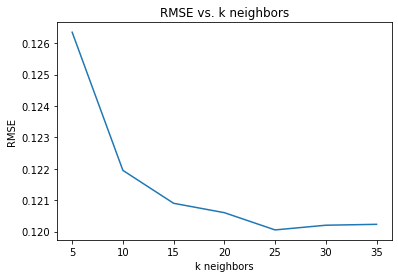

In [34]:
plt.plot(x,y)
plt.title("RMSE vs. k neighbors")
plt.ylabel("RMSE")
plt.xlabel("k neighbors")

# 25 seems to be where the dropoff stops

## Test effect of N Factors on RMSE for N Factors in SVD

In [36]:
x = np.arange(2, 161, 5)
y = np.zeros_like(x, dtype=float)
for i, n in enumerate(x):
    print(n)
    algo = SVD(n_factors=n)
    y[i] = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)['test_rmse'].mean() 

2
22
42
62
82
102
122
142


Text(0.5, 0, 'N factors')

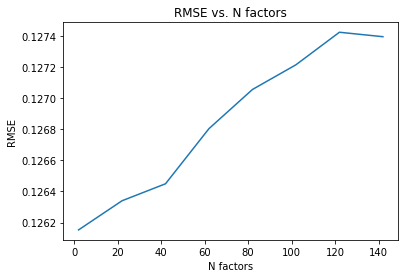

In [37]:
plt.plot(x,y)
plt.title("RMSE vs. N factors")
plt.ylabel("RMSE")
plt.xlabel("N factors")

# RMSE does not change much with n

## Test available classifiers on champion data

SVD - predict a user's rating of a given champion, accounting for their individual bias.

SVD++ - extension of SVD, accounting for implicit ratings, which accounts for the fact that a user rated item j without accouting for the given value (the user looked at this value)

Baseline - predicts baseline estimate for given user and item

Random - give a random rating based on distribution of training set

NMF - based on Non-negative Matrix Factorization, similar to SVD - algorithm highly dependent on initial values

Slope One - predict users preference for particular item based on preferences of other users

Co-clustering - users and items assigned clusters

k-NN Basic - aggregate of neighbors

Centered k-NN - aggregate of neighbors, but the mean rating of each user is accounted for

k-NN baseline - k-nn, but a baseline rating is accounted for

In [40]:
sim_options = {
    "name": "pearson_baseline",
    "user_based": False
}

k = 25
classifiers = [BaselineOnly(), SVD(), SVDpp(), NormalPredictor(), NMF(), \
               SlopeOne(), CoClustering(n_cltr_u = 3, n_cltr_i = 3), KNNBasic(k=k, sim_options=sim_options), \
               KNNWithMeans(k=k, sim_options=sim_options), KNNBaseline(k=k, sim_options=sim_options)]

labels = ['Baseline', 'SVD', 'SVDpp', 'Random', 'NMF', 'Slope One', 'Co-clustering', 'KNN', 'KNN With Means','KNN Baseline']

results = {}
for (cls, tag) in zip(classifiers, labels):
    print(tag)
    res = cross_validate(cls, data, measures=['RMSE', 'MAE', 'FCP'], cv=5, verbose=False)
    results[tag] = results[entry] = {"RMSE": res['test_rmse'].mean(), "MAE": res['test_mae'].mean(), 'FCP': res['test_fcp'].mean(), 'Test Time': res['test_time'][-1]}

Baseline
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE, FCP of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1288  0.1249  0.1279  0.1243  0.1242  0.1260  0.0019  
MAE (testset)     0.0603  0.0592  0.0600  0.0586  0.0592  0.0594  0.0006  
FCP (testset)     0.6825  0.6845  0.6876  0.6850  0.6819  0.6843  0.0020  
Fit time          0.09    0.10    0.10    0.10    0.10    0.10    0.00    
Test time         0.21    0.09    0.16    0.16    0.09    0.14    0.04    
SVD
Evaluating RMSE, MAE, FCP of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1273  0.1294  0.1263  0.1241  0.1276  0.1269  0.0017  
MAE (testset)     0.0607  0.0610  0.0606  0.0602  0.0607  0.0606  0.0003  
FCP (testset)     0.6366  0.63

### Analysis

KNN outperforms the other algorithms by every metric, with KNN With Means performing the best out of the KNN algorithms. NMF, Baseline, and SVD/SVDpp, SlopeOne seem to be a tier below kNN.

In [41]:
pprint.pprint(results)

{'Baseline': {'FCP': 0.6843162583080792,
              'MAE': 0.05944492513619173,
              'RMSE': 0.12600886746042067,
              'Test Time': 0.09462499618530273},
 'Co-clustering': {'FCP': 0.5041314097806556,
                   'MAE': 0.04122839206054664,
                   'RMSE': 0.1330422480646681,
                   'Test Time': 0.10592293739318848},
 'KNN': {'FCP': 0.7251525867726514,
         'MAE': 0.05406199202150815,
         'RMSE': 0.12191276514841913,
         'Test Time': 3.0844578742980957},
 'KNN Baseline': {'FCP': 0.7327118786398701,
                  'MAE': 0.05397387174470698,
                  'RMSE': 0.12042695680333455,
                  'Test Time': 3.450399875640869},
 'KNN With Means': {'FCP': 0.7343783872810599,
                    'MAE': 0.05389375009638484,
                    'RMSE': 0.12023861178564517,
                    'Test Time': 3.192988872528076},
 'NMF': {'FCP': 0.6927416860347615,
         'MAE': 0.03708723546513932,
         'RMSE': 0

## Load in Champion Info

In [42]:
filename = '../data/champion.json'
with open(filename, 'r') as f:
    champ_data = json.load(f)

champion_list = []
for i, c in enumerate(champ_data['data'].keys()):
    champion_list.append(champ_data['data'][c]['id'])

## Load in User's 5 Most played champs

This is so we don't recommend them later.

In [44]:
file_path = all_champs
reader = Reader(sep=",", rating_scale=(0,1))
data = Dataset.load_from_file(file_path, reader)

In [45]:
most_played = {}

with open(file_path, 'r') as f:
    reader_obj = csv.reader(f)
    cur_id = ''
    most = []
    for row in reader_obj: 
        user_id, champion, score = row
        if cur_id != user_id:
            if cur_id != '':
                most_played[cur_id] = most
                most = []
            cur_id = user_id
        
        most.append(champion)

print(most_played['MzEBGR0jRhrI5WavtCro_wPmhfpSPhxyrWd6F48ZY4aH4j8W'])

['Hecarim', 'Irelia', 'Syndra', 'Galio', 'Kindred', 'Mordekaiser', 'Cassiopeia', 'Yone', 'XinZhao', 'Sett', 'Brand', 'Sylas', 'Ezreal', 'Khazix', 'Kayn', 'Jax', 'Evelynn', 'MasterYi', 'Akali', 'Olaf', 'RekSai', 'Rakan', 'Volibear', 'Fiddlesticks', 'Ashe', 'Aatrox', 'Ahri', 'Akshan', 'Alistar', 'Amumu', 'Anivia', 'Annie', 'Aphelios', 'AurelionSol', 'Azir', 'Bard', 'Belveth', 'Blitzcrank', 'Braum', 'Briar', 'Caitlyn', 'Camille', 'Chogath', 'Corki', 'Darius', 'Diana', 'Draven', 'DrMundo', 'Ekko', 'Elise', 'Fiora', 'Fizz', 'Gangplank', 'Garen', 'Gnar', 'Gragas', 'Graves', 'Gwen', 'Heimerdinger', 'Illaoi', 'Ivern', 'Janna', 'JarvanIV', 'Jayce', 'Jhin', 'Jinx', 'Kaisa', 'Kalista', 'Karma', 'Karthus', 'Kassadin', 'Katarina', 'Kayle', 'Kennen', 'Kled', 'KogMaw', 'KSante', 'Leblanc', 'LeeSin', 'Leona', 'Lillia', 'Lissandra', 'Lucian', 'Lulu', 'Lux', 'Malphite', 'Malzahar', 'Maokai', 'Milio', 'MissFortune', 'MonkeyKing', 'Morgana', 'Naafiri', 'Nami', 'Nasus', 'Nautilus', 'Neeko', 'Nidalee', 'Nil

## Train kNN model on full dataset

In [72]:
sim_options = {
    "name": "pearson_baseline",
    "user_based": False
}

trainset = data.build_full_trainset()
algo = KNNWithMeans(sim_options=sim_options)

algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


### Get Mean Rating of each champion

In [47]:
mean_rating = {}

for rating in trainset.all_ratings():
    __, iid, rate = rating
    iid = trainset.to_raw_iid(iid)
    if iid not in mean_rating.keys():
        mean_rating[iid] = {'score': rate, 'n': 1, 'mean': rate}
    else:
        mean_rating[iid]['score'] += rate
        mean_rating[iid]['n'] += 1
        mean_rating[iid]['mean'] = mean_rating[iid]['score']/mean_rating[iid]['n']

In [82]:
def get_top_n(uid, champion_list):
    top_n = defaultdict(list)
    for champ in champion_list:
        top_n[uid].append((champ,algo.predict(uid, champ).est))
        #top_n[uid].append((champ,algo.predict(uid, champ).est/mean_rating[iid]['mean']))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings

    return top_n[uid]

def recommendChampion(uid, champs_played, champion_list, algo, n=10, ignore=5):
    print(f'User ID: {uid}')
    pprint.pprint(champs_played[:ignore])
    print(f'Recommendations for {uid}')
    count = 0
    for rec in get_top_n(uid, champion_list):
        if count >= 5:
            break
        if rec[0] not in champs_played[:ignore]:
            print(count+1, rec[0])
            count += 1


In [86]:
test_IDS = ['jBZi44QpCh3Ziwz30Na4rG3hT4f3dS0V7PanMs9qM_xXZTzZ', 'XmkVHqwlmKUd1JRuaWL6SshQYaIUn3-oWBDRaQDFlTQymrMG', 'h5D-yYexQgcqENJKCwm1VGjWkTdGCOz8ff2YIOB7b-VFCDvE', 'AqRWUr3C46RW6tNpOfmItiNc1fTI8ma5sBpkfJLo45kaZXEc', 'HpXI4tMjKDx3ySSN0fXBYBh3zqtvEW2xDgQG6eKyamQN9k9F', 'Ovy0KZGs2bdtLi3fddWlzRFJnQ-3KP2iIuu-1ot78uavttEw', 'iBW2XaXpV5EiN4Q3gad7iPvH_OsUUrPmJU_DOgRupxijvSky', 'qooS5-gypYBXZyohTzWCu3U-tDilF8ctYnRCMksC-ay_wIOb', 't19gUDiztyy4M5BCWino-GWRAsvdu_XT4c17ZJaREP1Rniw3', 'D_he0g8G_fNfoJZSfLCXL-Bak73E6cKNlvxo8SBP7d08SDbV']
for i in test_IDS:
    recommendChampion(i, most_played[i], champion_list, algo, n=5, ignore=10)

User ID: jBZi44QpCh3Ziwz30Na4rG3hT4f3dS0V7PanMs9qM_xXZTzZ
['Ezreal',
 'Jhin',
 'Ashe',
 'Kaisa',
 'Varus',
 'Zeri',
 'Akali',
 'Nasus',
 'Leona',
 'Kayle']
Recommendations for jBZi44QpCh3Ziwz30Na4rG3hT4f3dS0V7PanMs9qM_xXZTzZ
1 Caitlyn
2 Jinx
3 Aphelios
4 Vayne
5 Yasuo
User ID: XmkVHqwlmKUd1JRuaWL6SshQYaIUn3-oWBDRaQDFlTQymrMG
['Talon',
 'MasterYi',
 'XinZhao',
 'Jayce',
 'Ekko',
 'Jax',
 'Nidalee',
 'Fizz',
 'Elise',
 'Garen']
Recommendations for XmkVHqwlmKUd1JRuaWL6SshQYaIUn3-oWBDRaQDFlTQymrMG
1 Yasuo
2 Kayn
3 Darius
4 Fiora
5 Zed
User ID: h5D-yYexQgcqENJKCwm1VGjWkTdGCOz8ff2YIOB7b-VFCDvE
['Lux',
 'Janna',
 'Neeko',
 'Soraka',
 'Ahri',
 'Morgana',
 'Nami',
 'Xerath',
 'Sona',
 'Malzahar']
Recommendations for h5D-yYexQgcqENJKCwm1VGjWkTdGCOz8ff2YIOB7b-VFCDvE
1 Seraphine
2 MissFortune
3 Lulu
4 Caitlyn
5 Senna
User ID: AqRWUr3C46RW6tNpOfmItiNc1fTI8ma5sBpkfJLo45kaZXEc
['Warwick',
 'Sejuani',
 'Khazix',
 'Kaisa',
 'Graves',
 'Caitlyn',
 'Evelynn',
 'XinZhao',
 'Hecarim',
 'Lillia']
Recommenda

In [88]:
test_IDS = []

for i in range(5):
    test_IDS.append(random.choice(list(most_played.keys())))
for i in test_IDS:
    recommendChampion(i, most_played[i], champion_list, algo, n=5, ignore=10)

User ID: WRfDNlcKHJ4qcioPUlU-PX1i7jl5hm0PHAwC0rd8PYGBY2z0
['MissFortune',
 'Swain',
 'Ashe',
 'Senna',
 'Soraka',
 'Seraphine',
 'Morgana',
 'Evelynn',
 'Jinx',
 'Lux']
Recommendations for WRfDNlcKHJ4qcioPUlU-PX1i7jl5hm0PHAwC0rd8PYGBY2z0
1 Caitlyn
2 Brand
3 Ahri
4 Ezreal
5 Kaisa
User ID: ICojeBCx7vNEHqwEyyi2k4RkXtEfxqL_R3a6ZGdftk2QsdER
['Senna',
 'Caitlyn',
 'Ezreal',
 'Sivir',
 'Mordekaiser',
 'Viego',
 'MissFortune',
 'Nautilus',
 'Olaf',
 'Brand']
Recommendations for ICojeBCx7vNEHqwEyyi2k4RkXtEfxqL_R3a6ZGdftk2QsdER
1 Jhin
2 Ashe
3 Kaisa
4 Tristana
5 Lux
User ID: 4ST4chMqUvVefHUIdHesRY6u1V4czhqGlJa5zzIIgsHLq2xv
['Olaf',
 'Kayn',
 'Volibear',
 'Skarner',
 'Belveth',
 'Nocturne',
 'DrMundo',
 'Evelynn',
 'Jayce',
 'Elise']
Recommendations for 4ST4chMqUvVefHUIdHesRY6u1V4czhqGlJa5zzIIgsHLq2xv
1 Warwick
2 MasterYi
3 Khazix
4 Yasuo
5 Hecarim
User ID: mqLUcR7aZxmWNoEXw43ittEz1AZyjya8jfmuzR-9ucVIs3N9
['Urgot',
 'Malzahar',
 'Orianna',
 'Veigar',
 'Quinn',
 'Mordekaiser',
 'Ryze',
 'Pantheon'